# Introduction

Authors
* Kush **Gupta**, kushg1121@gmail.com
* Sebestyén **Németh**, nemeth.sbn@gmail.com

## Example 1 : Reading and displaying an image

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from math import floor
from scipy.signal import convolve2d
from tqdm import tqdm

In [ ]:
!mkdir -p images
!wget -q https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif -O images/cameraman.tif

In [ ]:
# Read file .png
#Im_PIL = Image.open('images/cameraman.png') 
Im_PIL = Image.open('images/cameraman.tif')

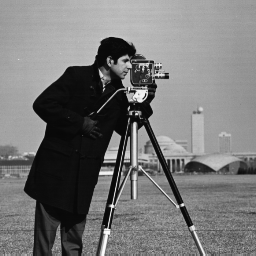

In [ ]:
Im_PIL

In [ ]:
type(Im_PIL)

PIL.TiffImagePlugin.TiffImageFile

In [ ]:
# convert the PIL image to an array
Im_data = np.array(Im_PIL)

In [ ]:
(Im_data / 255).dtype

dtype('float64')

In [ ]:
# display
bounds = {'vmin': 0, 'vmax': 255}

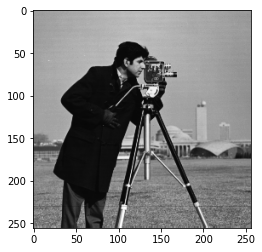

In [ ]:
plt.imshow(Im_data, cmap='gray', **bounds)
plt.show()

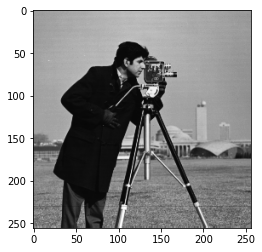

In [ ]:
plt.imshow(Im_data / 255, cmap='gray', vmin=0, vmax=1)
plt.show()

## Example 2 : Avoid `for` loops

In [ ]:
N = 2_000

A = np.ones((N, N))
B = np.random.rand(N, N)
C = np.empty_like(A)

In [ ]:
%%time
for i in range(N):
    for j in range(N):
        C[i, j] = A[i, j] * B[i, j]

CPU times: user 4.2 s, sys: 48.1 ms, total: 4.25 s
Wall time: 5.66 s


In [ ]:
%%time
C = A * B

CPU times: user 11.7 ms, sys: 20 ms, total: 31.8 ms
Wall time: 76.3 ms


## Example 3 : Adding gaussian noise to an image with a function

In [ ]:
def add_gaussian_noise(I, s):
    m, n = I.shape
    I_out = I + s * np.random.randn(m, n)
    
    return I_out

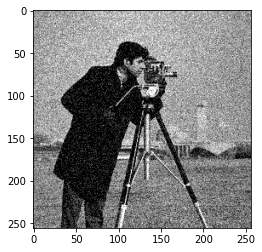

In [ ]:
Im_noised = add_gaussian_noise(Im_data, s=30)

plt.imshow(Im_noised, cmap='gray', **bounds)

plt.show()

# Denoising with PDEs 

In [ ]:
def scalar_product(u, v):
  return np.dot(u, v)

def norm(u):
  return np.linalg.norm(u)

In [ ]:
def gradient(u):
  m, n = u.shape
  grad_u = np.zeros((2, m, n))
  
  grad_u[0, :-1, :] = u[1:] - u[:-1]
  
  grad_u[1, :, :-1] = u[:, 1:] - u[:, :-1]
  
  return grad_u

In [ ]:
def div(p):
  m, n = p.shape[1:]
  
  div_1 = np.zeros((m, n))
  div_1[:-1, :] = p[0, :-1, :]
  div_1[1:, :] -= p[0, :-1, :]
  
  div_2 = np.zeros((m, n))
  div_2[:, :-1] = p[1, :, :-1]
  div_2[:, 1:] -= p[1, :, :-1]
  
  return div_1 + div_2

In [ ]:
def laplacian(u):
  return div(gradient(u))

## 1

In [ ]:
def heat_equation(f, dt, K):
  u = np.copy(f)
  for k in range(K):
    u += dt * laplacian(u) 
  return u

## 2

**Observation**: as K is increasing, we are getting a more blurred image. This reduces the noise in the image but also degrades the contours, we lose information.

In [ ]:
Im_noised = heat_equation(Im_noised, 1/8, 0)
Im_rec_K20 = heat_equation(Im_noised, 1/8, 20)
Im_rec_K100 = heat_equation(Im_noised, 1/8, 100)

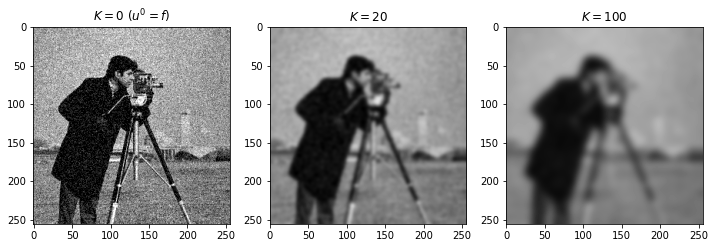

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

axes[0].set_title("$K = 0 \ (u^0 = f)$")
axes[0].imshow(Im_noised, cmap='gray', **bounds)

axes[1].set_title("$K = 20$")
axes[1].imshow(Im_rec_K20, cmap='gray', **bounds)

axes[2].set_title("$K = 100$")
axes[2].imshow(Im_rec_K100, cmap='gray', **bounds)

plt.show()

## 3 

In [ ]:
def gaussian_kernel(dt, K):
  ssq = 2*K*dt
  P = floor(K * dt + 1)
  g = lambda x, y: 1/(2*np.pi*ssq) * np.exp(-1*((x-P+1)**2 + (y-P+1)**2)/(2*ssq))
  x, y = np.meshgrid(range(2*P-1), range(2*P-1))
  result = g(x, y)
  return result / np.sum(result)

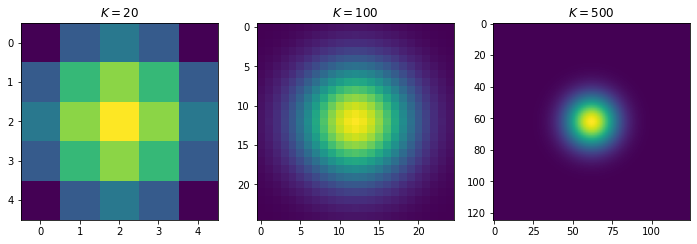

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

axes[0].set_title("$K = 20$")
axes[0].imshow(gaussian_kernel(1/8, 20))

axes[1].set_title("$K = 100$")
axes[1].imshow(gaussian_kernel(1/8, 100))

axes[2].set_title("$K = 500$")
axes[2].imshow(gaussian_kernel(1/8, 500))

plt.show()

## 4 

In [ ]:
def convolve(f, G):
  return convolve2d(f, G, boundary='symm', mode='same')

## 5

**Observation**: We can confirm visually that both the heat equation and the convolution with the gaussian kernel produce the same effect on the image. An important aspect is to normalize the gaussian kernel. For computational reasons we can observe a subtle difference in the amount of the blurring effect.

In [ ]:
Im_rec_K20 = heat_equation(Im_noised, 1/8, 20)
Im_rec_K100 = heat_equation(Im_noised, 1/8, 100)
Im_rec_K500 = heat_equation(Im_noised, 1/8, 500)

G_20 = gaussian_kernel(1/8, 20)
Im_est_G_20 = convolve(Im_noised, G_20)
G_100 = gaussian_kernel(1/8, 100)
Im_est_G_100 = convolve(Im_noised, G_100)
G_500 = gaussian_kernel(1/8, 500)
Im_est_G_500 = convolve(Im_noised, G_500)

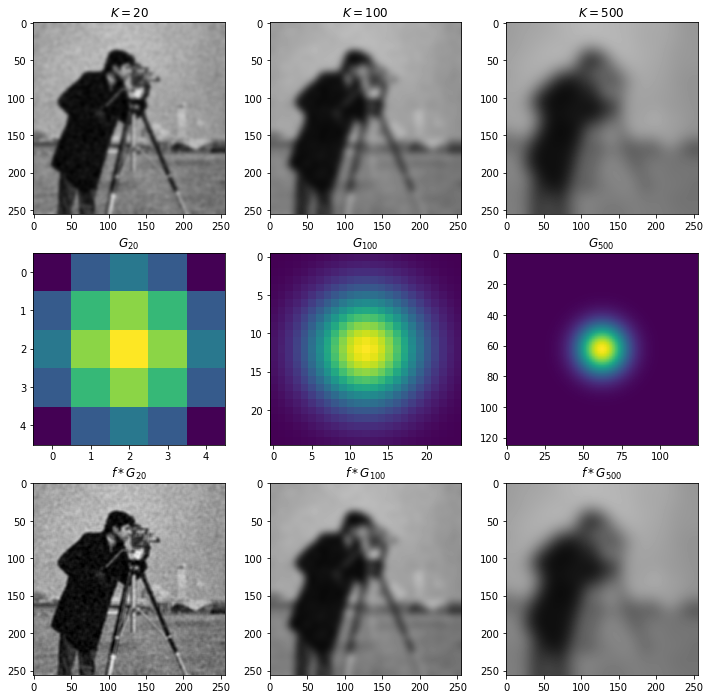

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

axes[0, 0].set_title("$K = 20$")
axes[0, 0].imshow(Im_rec_K20, cmap='gray', **bounds)

axes[0, 1].set_title("$K = 100$")
axes[0, 1].imshow(Im_rec_K100, cmap='gray', **bounds)

axes[0, 2].set_title("$K = 500$")
axes[0, 2].imshow(Im_rec_K500, cmap='gray', **bounds)


axes[1, 0].set_title("$G_{20}$")
axes[1, 0].imshow(G_20)

axes[1, 1].set_title("$G_{100}$")
axes[1, 1].imshow(G_100)

axes[1, 2].set_title("$G_{500}$")
axes[1, 2].imshow(G_500)


axes[2, 0].set_title("$f * G_{20}$")
axes[2, 0].imshow(Im_est_G_20, cmap='gray', **bounds)

axes[2, 1].set_title("$f * G_{100}$")
axes[2, 1].imshow(Im_est_G_100, cmap='gray', **bounds)

axes[2, 2].set_title("$f * G_{500}$")
axes[2, 2].imshow(Im_est_G_500, cmap='gray', **bounds)

plt.show()

## 6 

**Observations**: The `grad_edge` filter finds suffiently large changes in the image, parametrized with $\eta$. If we apply it on a reasonably blurred image, then the edges highlighted by the filter will be thick. The `lap_edge` however finds edges irrespectively of the amount of the change. This means it will find thin edges on large and small gradient changes as well.

In [ ]:
def grad_edge(u, eta):
  return np.linalg.norm(gradient(u), axis=0) > eta

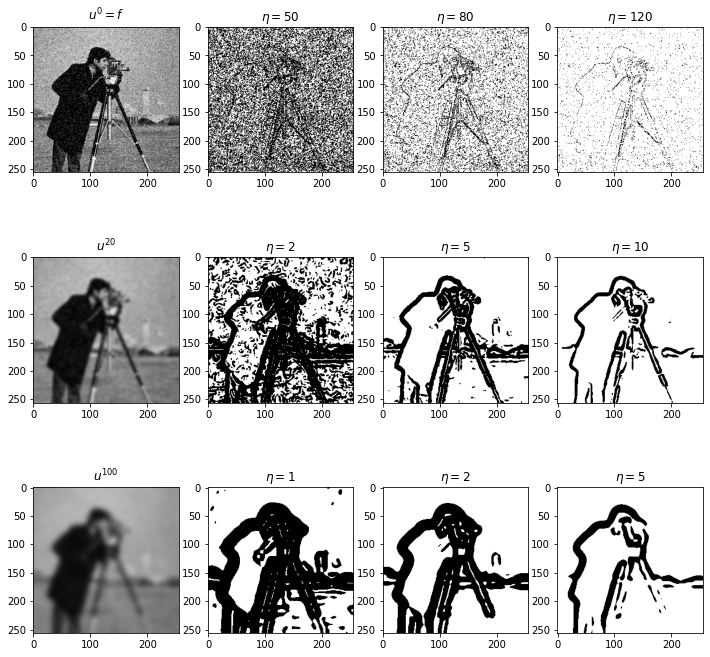

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for row, (title, Im) in enumerate(zip(["$u^0 = f$", "$u^{20}$", "$u^{100}$"], 
                                      [Im_noised, Im_rec_K20, Im_rec_K100])):
    axes[row, 0].set_title(title)
    axes[row, 0].imshow(Im, cmap='gray', **bounds)

for col, eta in enumerate([50, 80, 120], start=1):
    axes[0, col].set_title(f"$\eta = {eta}$")
    axes[0, col].imshow(1 - grad_edge(Im_noised, eta=eta), cmap='gray')

for col, eta in enumerate([2, 5, 10], start=1):
    axes[1, col].set_title(f"$\eta = {eta}$")
    axes[1, col].imshow(1 - grad_edge(Im_rec_K20, eta=eta), cmap='gray')

for col, eta in enumerate([1, 2, 5], start=1):
    axes[2, col].set_title(f"$\eta = {eta}$")
    axes[2, col].imshow(1 - grad_edge(Im_rec_K100, eta=eta), cmap='gray')

plt.show()

In [ ]:
def change_sign(J):
    bool_map = np.full_like(J, False, dtype=bool)
    
    prod_ver = (J[:-1, :] * J[1:, :]) <= 0
    diff_abs_ver = abs(J[:-1, :]) - abs(J[1:, :])
    
    prod_hor = (J[:, :-1] * J[:, 1:]) <= 0
    diff_abs_hor = abs(J[:, :-1]) - abs(J[:, 1:])
    
    bool_map[:-1, :] |= prod_ver & (diff_abs_ver <= 0)
    bool_map[1:, :] |= prod_ver & (diff_abs_ver > 0)
    
    bool_map[:, :-1] |= prod_hor & (diff_abs_hor <= 0)
    bool_map[:, 1:] |= prod_hor & (diff_abs_hor > 0)
    
    return bool_map


In [ ]:
def lap_edge(u):
  return change_sign(laplacian(u))

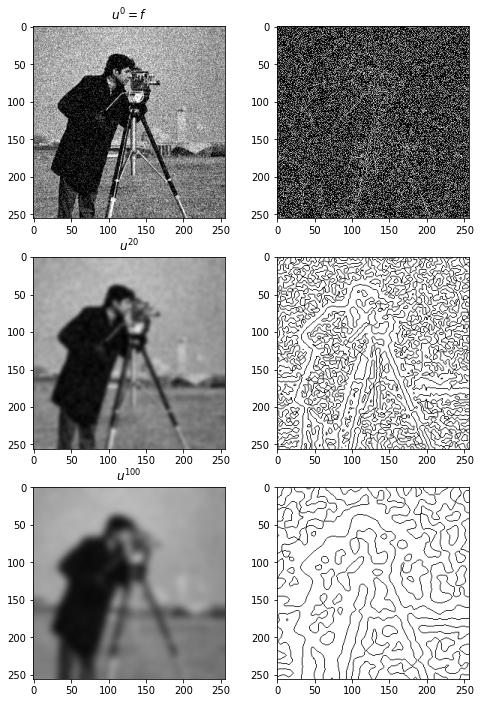

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))


for row, (title, Im) in enumerate(zip(["$u^0 = f$", "$u^{20}$", "$u^{100}$"], 
                                      [Im_noised, Im_rec_K20, Im_rec_K100])):
    axes[row, 0].set_title(title)
    axes[row, 0].imshow(Im, cmap='gray', **bounds)
    axes[row, 1].imshow(1 - lap_edge(Im), cmap='gray')

plt.show()

In [ ]:
def Marr_Hildreth(u, eta):
  return grad_edge(u, eta) * lap_edge(u)

## 7 

**Observation**: The Marr-Hildreth filter combines the above-mentioned filters in a way that it finds thin edges (the inflection line of the contours), but only where the gradient is sufficiently large (for given $\eta$). When applied to noisy image, we need a high $\eta$, since the gradients are high. However, if we smooth the image, we will have smaller gradients, so high $\eta$ will filter out everything, hence we need a lower value.

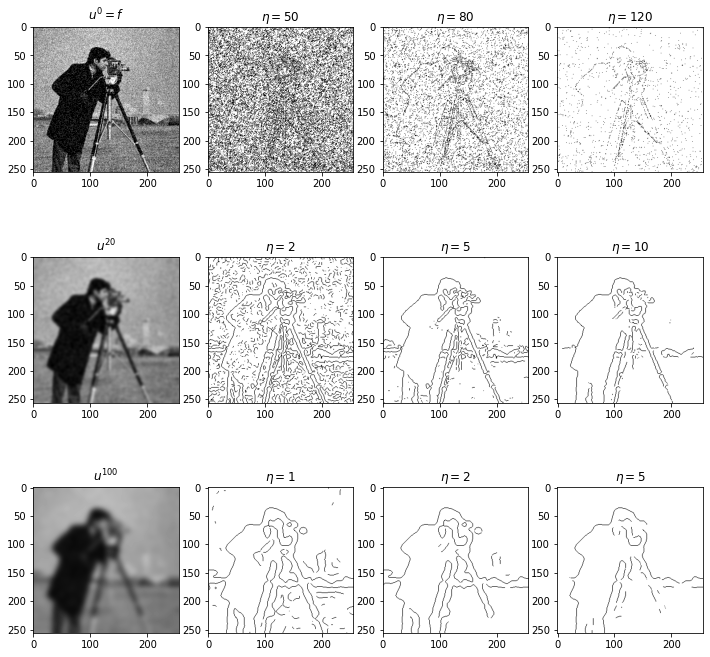

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for row, (title, Im) in enumerate(zip(["$u^0 = f$", "$u^{20}$", "$u^{100}$"], 
                                      [Im_noised, Im_rec_K20, Im_rec_K100])):
    axes[row, 0].set_title(title)
    axes[row, 0].imshow(Im, cmap='gray', **bounds)

for col, eta in enumerate([50, 80, 120], start=1):
    axes[0, col].set_title(f"$\eta = {eta}$")
    axes[0, col].imshow(1 - Marr_Hildreth(Im_noised, eta=eta), cmap='gray')

for col, eta in enumerate([2, 5, 10], start=1):
    axes[1, col].set_title(f"$\eta = {eta}$")
    axes[1, col].imshow(1 - Marr_Hildreth(Im_rec_K20, eta=eta), cmap='gray')

for col, eta in enumerate([1, 2, 5], start=1):
    axes[2, col].set_title(f"$\eta = {eta}$")
    axes[2, col].imshow(1 - Marr_Hildreth(Im_rec_K100, eta=eta), cmap='gray')

plt.show()

## 8

In [ ]:
def g_exp(xi, alpha=1):
  return np.exp(- (xi / alpha)**2)

def g_PM(xi, alpha=1):
  return 1/np.sqrt((xi/alpha)**2 + 1)

In [ ]:
def Perona_Malik(f, dt, K, alpha, g=g_PM):
  u = np.copy(f)
  for k in range(K):
    u += dt * div(g(np.linalg.norm(gradient(u), axis=0), alpha)*gradient(u))
  return u

## 9

**Observations**: As we increase the value of $K$ and $\alpha$ independently, the image gets blurrier. We can verify $K_{opt}(s)$ and $\alpha_{opt}(s)$ are both linear functions, i.e. the optimal value of the number of iterations $K$ and the blurring parameter $\alpha$ is proportional to the deviation $s$ of the noise at the image.

\begin{aligned}{\mathit {PSNR}}&=10\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}^{2}}{\mathit {MSE}}}\right)\\&=20\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}}{\sqrt {\mathit {MSE}}}}\right)\\&=20\cdot \log _{10}({\mathit {MAX}}_{I})-10\cdot \log _{10}({\mathit {MSE}}).\end{aligned}

In [ ]:
def MSE(f, u):
  return ((f - u)**2).mean()
def PSNR(f, u):
  return 20 * np.log10(np.max(f)) - 10 * np.log10(MSE(f, u))

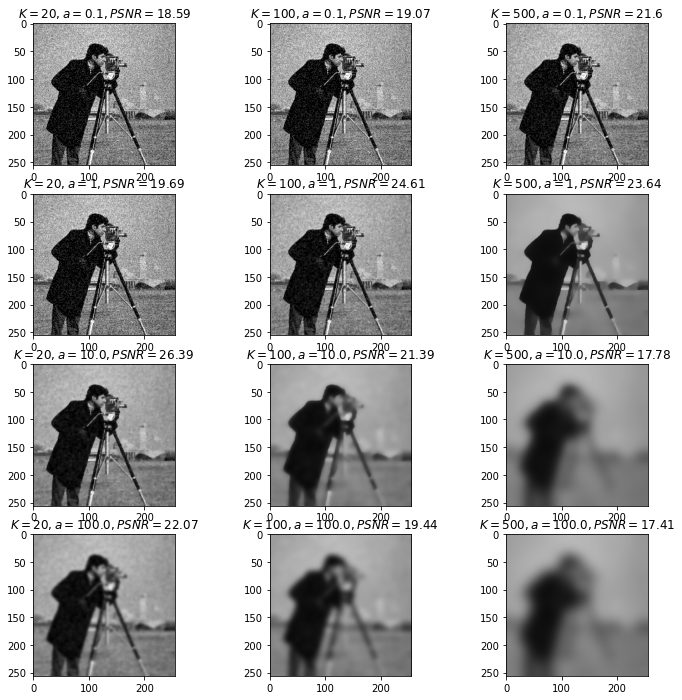

In [ ]:
alphas = [1e-1, 1, 1e1, 1e2]
Ks = [20, 100, 500]

fig, axes = plt.subplots(nrows=len(alphas), ncols=len(Ks), figsize=(12, 12))

for i, alpha in enumerate(alphas):
  for j, K in enumerate(Ks):
    img_PM = Perona_Malik(Im_noised, 1/8, K, alpha)
    psnr = PSNR(Im_data, img_PM)
    axes[i][j].set_title(f"$K = {K}, a = {alpha}, PSNR = {np.round(psnr, 2)}$")
    axes[i][j].imshow(img_PM, cmap='gray', **bounds)

plt.show()

In [ ]:
s_range = list(range(10, 91, 15))
K_range = list(range(0, 401, 10))

K_opt = []
for s in tqdm(s_range):
  psnr = []
  noised = add_gaussian_noise(Im_data, s=s)
  for K in K_range:
    pm = Perona_Malik(noised, 1/8, K, 15)
    psnr.append(PSNR(Im_data, pm))
  opt_idx = np.argmax(np.array(psnr))
  K_opt.append(K_range[opt_idx])

100%|██████████| 6/6 [02:08<00:00, 21.36s/it]


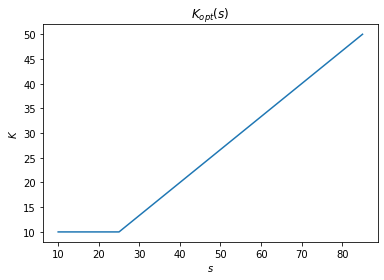

In [ ]:
plt.plot(s_range, K_opt)
plt.title("$K_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$K$")
plt.show()

In [ ]:
s_range = list(range(10, 91, 10))
a_range = list(range(1, 51, 2))

a_opt = []
for s in tqdm(s_range):
  psnr = []
  noised = add_gaussian_noise(Im_data, s=s)
  for a in a_range:
    pm = Perona_Malik(noised, 1/8, 30, a)
    psnr.append(PSNR(Im_data, pm))
  opt_idx = np.argmax(np.array(psnr))
  a_opt.append(a_range[opt_idx])

100%|██████████| 9/9 [00:18<00:00,  2.07s/it]


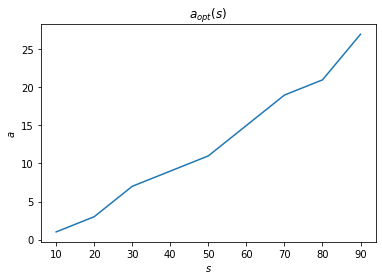

In [ ]:
plt.plot(s_range, a_opt)
plt.title("$a_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$a$")
plt.show()

## 10

**Observations**: For a smoother image (eg. $u^{200}$), the edges of detailed regions disappear, but the remaining edges mantain the localization of the contours, thus we preserve significant amount of information, though details are lost.

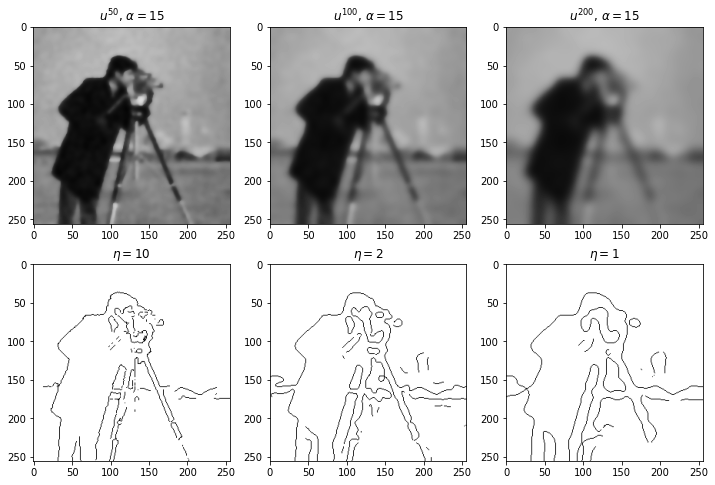

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

Ks = [50, 100, 200]
alphas = [15, 15, 15]
etas = [10, 2, 1]
for row, (K, alpha, eta) in enumerate(zip(Ks, alphas, etas)):
    Im_rec_PM_1 = Perona_Malik(Im_noised, dt=1/8, K=K, alpha=alpha)
    axes[0, row].set_title(f"$u^{{{K}}}$, $\\alpha = {alpha}$")
    axes[0, row].imshow(Im_rec_PM_1, cmap='gray', **bounds)
    axes[1, row].set_title(f"$\eta = {eta}$")
    axes[1, row].imshow(1 - Marr_Hildreth(Im_rec_PM_1, eta=eta), cmap='gray')

plt.show()

## 11 

**Observations**: The optimal value of $L$ (the variance of the gaussian $G_L := G_s$) also follows a linear increasing in the function of the noise variance $s$. However, for small amounts of noise ($s$ smaller than $≈ 75$), the $L_{opt} = 1$, meaning we omit the blurring effect. This means that the improved model works better on noisier data, there is no improvement with respect to the original Perona-Malik, when the noise is comparably less. 

In [ ]:
def Perona_Malik_enhanced(f, dt, K, alpha, L, g=g_PM):
  u = np.copy(f)
  G = gaussian_kernel(dt, L)
  for _ in range(K):
    Gu = convolve(u, G)
    u += dt * div(g(np.linalg.norm(gradient(Gu), axis=0), alpha)*gradient(u))
  return u

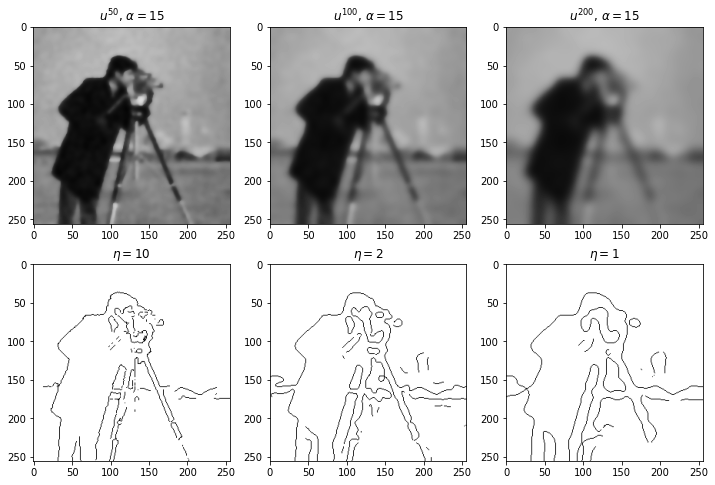

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

Ks = [50, 100, 200]
alphas = [15, 15, 15]
etas = [10, 2, 1]

for row, (K, alpha, eta) in enumerate(zip(Ks, alphas, etas)):
    Im_rec_PM_1 = Perona_Malik_enhanced(Im_noised, dt=1/8, K=K, alpha=alpha, L=1)
    axes[0, row].set_title(f"$u^{{{K}}}$, $\\alpha = {alpha}$")
    axes[0, row].imshow(Im_rec_PM_1, cmap='gray', **bounds)
    axes[1, row].set_title(f"$\eta = {eta}$")
    axes[1, row].imshow(1 - Marr_Hildreth(Im_rec_PM_1, eta=eta), cmap='gray')

plt.show()

In [ ]:
s_range = list(range(10, 201, 10))
L_range = list(range(1, 51, 5))

L_opt = []
for s in tqdm(s_range):
  psnr = []
  noised = add_gaussian_noise(Im_data, s=s)
  for L in L_range:
    pm = Perona_Malik_enhanced(noised, 1/8, 30, 15, L)
    psnr.append(PSNR(Im_data, pm))
  opt_idx = np.argmax(np.array(psnr))
  L_opt.append(L_range[opt_idx])

100%|██████████| 20/20 [01:24<00:00,  4.22s/it]


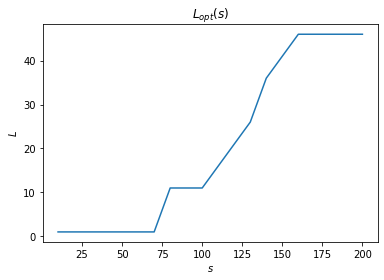

In [ ]:
plt.plot(s_range, L_opt)
plt.title("$L_{opt}(s)$")
plt.xlabel("$s$")
plt.ylabel("$L$")
plt.show()